# Homework Set 5

In [35]:
%pylab inline
import pandas as pd

import sys
import fmt

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Problem 1:

Use the following historical CMT data set for the this problem,

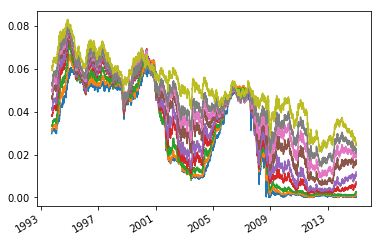

In [36]:
cmturl = "https://raw.githubusercontent.com/yadongli/nyumath2048/master/data/cmt.csv"
cmt_rates = pd.read_csv(cmturl, parse_dates=[0], index_col=[0])*.01

cmt_rates.plot(legend=False);
tenors = cmt_rates.columns.map(float)
tenorTags = ['T=%g' % m for m in tenors]

and suppose today's zero rate term structure is given below, and all rates are continously compounding:

In [37]:
t = pd.to_numeric(cmt_rates.columns).values
r = cmt_rates.iloc[-1, :].values

fmt.displayDF(pd.DataFrame(r, index=t, columns=['Zero Rate (%)']).T*100, fmt="4g")

,0.25,0.5,1.0,2.0,3.0,5.0,7.0,10.0,20.0
Zero Rate (%),0.01,0.1,0.26,0.73,1.19,1.75,2.07,2.25,2.54


1. use the tension spline routine from previoius homework to build a tension spline of zero rate term structure $r(t)$ with $\lambda = 5$, you can assume $r(0) = 0$ if needed. Note that we are interpolating the zero rate instead of the cumulative yield here.
2. suppose the liquid market securities (the benchmarks) are 3M deposit (equivalent to zero coupon bond), and swaps paying semi-annual coupons with maturities matching the CMT quotes tenors;  use the curve you built to price these benchmark securities, assuming the deposits are quoted by the continous yield (zero rate) and swaps are quoted in break even spreads (par swap spreads).
3. use your bootstrap functions from the previous homework/lecture to bootstrap the zero rate curve from benchmark quotes from #2, show that the resulting curve is identical to the curve from #1. 
4. You have an aged receiver swap (receiving fixed) on the book with $100M notional, 6Y of remaining maturity and 5% semi-annual fixed coupon. Compute its deltas and hedge notionals to the benchmark instruments by bumping the market quotes of benchmark instruments (ie, deposit and swaps) and re-bootstrapping the IR curve, record the computation time for hedge notionals.
5. Suppose your system only computes the risks to the zero rates, compute the risk of the aged trade to zero rates, and the Jacobian matrix and use them to compute the hedge notionals, compare the results and computation time to the previous step. 

Hint:
* you can use the swap.py library from last homework to price swaps.
* please pay attention to the compounding, there are multiple compounding in this problem: all the zero rates are continuously compounded, the swaps pays coupon semi-annually, therefore the par swap quotes should be computed using the correct coupon frequency. The first deposit is quoted by yield (zero rate), which is countinuously compounded.
* The 3M deposit is equivalent to a 3M swap in risk profile, therefore, you may replace the 3M deposit by a quarterly par swap maturing at 3M as the first benchmark instruments during the bootstrap. It may ease the coding, as you can re-use the same swap pricer. But beware the quarterly par swap rate is different from continuous compounded zero rate, thus a proper conversion is required.

### Solution

1: the following is the zero rate curve with $\lambda = 5$

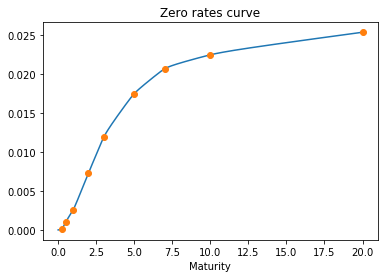

In [38]:
import lin

lbd = 5.
c0 = lin.RationalTension(lbd)
c0.build(np.concatenate(([0], t)), np.concatenate(([0], r)))

td = np.arange(.01, 20, .01)
plot(td, c0(td))
plot(t, r, 'o')
xlabel('Maturity')
title('Zero rates curve');

2: the benchmark prices from the curve above, note the 3M deposite rate is the same as 3M zero rate.

In [39]:
import inst
from swap import Swap, priceSwap, swapParSpread

def r2disc(curve) :
    return lambda ts: np.exp(-curve(ts)*ts)

swapPar = [swapParSpread(m, r2disc(c0), freq=2) for m in t[1:]]
bmkTags = ['Deposit @t=%g' % t[0]] + ['Swap @t=%g' % m for m in t[1:]]

fmt.displayDF(pd.DataFrame([[r[0]] + swapPar], columns=bmkTags, index=['Benchmark Quotes']), "3g")

,Deposit @t=0.25,Swap @t=0.5,Swap @t=1,Swap @t=2,Swap @t=3,Swap @t=5,Swap @t=7,Swap @t=10,Swap @t=20
Benchmark Quotes,0.0001,0.001,0.0026,0.00729,0.0119,0.0173,0.0204,0.0222,0.0249


3: Note that the 3M deposit quote is equivalent to a swap quote with quarterly payment maturing in 3M for curve building. However, the coupon rate of the 3M swap are quaterly compounded instead of continously compounded, therefore a conversion from continuous to quarterly compounding rate is needed. The following chart shows the bootstrapped curve has identical knot values to those from #1.

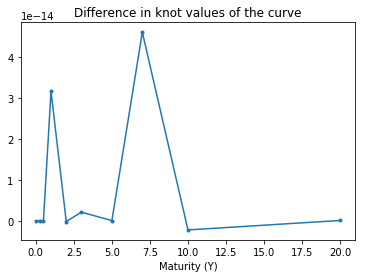

In [40]:
def cont2simp(r, t, freq) :
    d = np.exp(-r*t)
    return ((1./d)**(1./(t*freq)) - 1.)*freq

# the pfunc if we interpolate zero rate r(t)
def r2pv(swap, cv) :
    return priceSwap(swap, r2disc(cv))

# create the benchmark instruments
bm_swaps = {Swap(m, c, 2) : 0 for m, c in zip (t[1:], swapPar)}
bm_swaps[Swap(t[0], cont2simp(r[0], t[0], 4), 4)] = 0. # the deposit can be viewed as a swap maturing at 1/4 year

c1, e = inst.iterboot(bm_swaps, r2pv, x0=0., bds=[-1., 1.], lbd = lbd, make_curve=lin.RationalTension)

plot(c1.x, c1.y - c0.y, '.-');
xlabel('Maturity (Y)')
title('Difference in knot values of the curve');

4: we follow the convention that the positive sign of the swap notional means receiver swap (receiving fixed), and negative notional means payer swap. In this case, since the benchmark instruments' quotes are bumped, the Jacobian matrix is diagonal, thus we only show the diagonal elements (PV01s).

In [41]:
def pert_bmk(bms, lbd, its, delta=1e-4) :
    bms_pert = {Swap(s.maturity, s.coupon + delta, s.freq) : v for s, v in bms.items()} 
    cs = []
    
    for s in sorted(bms_pert.keys(), key=lambda s : s.maturity) :
        bms_p1 = {(k if k.maturity != s.maturity else s) : v for k, v in bms.items()}
        c1, _ = inst.iterboot(bms_p1, r2pv, x0=0., bds=[-1., 1.], lbd=lbd, its = its)
        cs.append(c1)
        
    return cs

dspr = 1e-4
bespoke = Swap(maturity=6., coupon=0.05, freq=2.)
insts = [k for k in sorted(bm_swaps.keys(), key=lambda s:s.maturity)]
notional = 100e6

In [42]:
import time

tic = time.time()
pc_bmk = pert_bmk(bm_swaps, lbd=lbd, its=3, delta=dspr)
pv01 = np.array([r2pv(i, c) for i, c in zip(insts, pc_bmk)])/dspr
pvb0 = r2pv(bespoke, c1)
deltas_bmk = np.array([r2pv(bespoke, c) - pvb0 for c in pc_bmk])
hr = deltas_bmk/pv01/dspr
dt1 = time.time() - tic

print("computation takes %g sec\n" % dt1)

print("Hedging portfolio")
h_bmk = pd.DataFrame([np.abs(pv01), deltas_bmk*notional, hr, -hr*notional], 
                  index=['PV01', 'Bespoke Delta', 'Hedge Ratio', 'Hedge Notional'], columns=bmkTags)
fmt.displayDF(h_bmk, "5g")

computation takes 2.17645 sec

Hedging portfolio


,Deposit @t=0.25,Swap @t=0.5,Swap @t=1,Swap @t=2,Swap @t=3,Swap @t=5,Swap @t=7,Swap @t=10,Swap @t=20
PV01,0.24999,0.49973,0.9984,1.9874,2.9579,4.8284,6.5972,9.0745,16
Bespoke Delta,-2.6563,-56.175,-238.89,-835.66,690.99,"-33,466","-30,021",991.2,-10.051
Hedge Ratio,0.0010626,0.011241,0.023928,0.042048,-0.023361,0.69311,0.45506,-0.010923,6.2818e-05
Hedge Notional,-1.0626e+05,-1.1241e+06,-2.3928e+06,-4.2048e+06,2.3361e+06,-6.9311e+07,-4.5506e+07,1.0923e+06,"-6,281.8"


5: the hedging portfolio from Jacobian inversion are very close to those from previous step, however, the Jacobian inversion is much faster.

In [43]:
def pert_r(ts, rs, lbd, dspr) :
    cs = []
    for i, _ in enumerate(rs) :
        c = lin.RationalTension(lbd)
        rp = np.copy(rs)
        rp[i] += dspr
        c.build(np.concatenate(([0.], ts)), np.concatenate(([0.], rp)))
        cs.append(c)
    
    return cs

tic = time.time()
pc_r = pert_r(t, r, lbd, dspr)
jacobian =  pd.DataFrame(np.array([[r2pv(i, c) for c in pc_r] for i in insts]), 
                         columns=['Pert %gY' % m for m in t], index=bmkTags)
deltas_r = np.array([r2pv(bespoke, c) - pvb0 for c in pc_r])
hr = deltas_r.dot(np.linalg.inv(jacobian))

dt2 = time.time() - tic
print("computation takes %g sec\n" % dt2)

print("Jacobian Matrix:")

fmt.displayDF(jacobian/dspr)

print("Hedging portfolio")
h_r = pd.DataFrame([deltas_r*notional, hr, -hr*notional], 
                  index=['Bespoke Delta', 'Hedge Ratio', 'Hedge Notional'], columns=bmkTags)
fmt.displayDF(h_r, "5g")

computation takes 0.0198085 sec

Jacobian Matrix:


,Pert 0.25Y,Pert 0.5Y,Pert 1Y,Pert 2Y,Pert 3Y,Pert 5Y,Pert 7Y,Pert 10Y,Pert 20Y
Deposit @t=0.25,-0.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Swap @t=0.5,0.0000,-0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Swap @t=1,0.0000,-0.0006,-0.9987,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000
Swap @t=2,-0.0001,-0.0013,-0.0069,-1.9808,0.0002,-0.0000,0.0000,-0.0000,0.0000
Swap @t=3,-0.0001,-0.0022,-0.0106,-0.0241,-2.9185,0.0002,-0.0000,0.0000,-0.0000
Swap @t=5,-0.0002,-0.0030,-0.0162,-0.0274,-0.0906,-4.6723,0.0029,-0.0001,0.0000
Swap @t=7,-0.0003,-0.0036,-0.0190,-0.0333,-0.1009,-0.1945,-6.1975,0.0024,-0.0000
Swap @t=10,-0.0003,-0.0039,-0.0206,-0.0358,-0.1113,-0.1898,-0.3737,-8.2626,0.0014
Swap @t=20,-0.0003,-0.0044,-0.0231,-0.0408,-0.1211,-0.2588,-0.0391,-1.8927,-13.3677


Hedging portfolio


,Deposit @t=0.25,Swap @t=0.5,Swap @t=1,Swap @t=2,Swap @t=3,Swap @t=5,Swap @t=7,Swap @t=10,Swap @t=20
Bespoke Delta,-5.3023,-93.369,-435.6,"-1,164.6",-392.96,"-33,248","-28,141",911.43,-8.6436
Hedge Ratio,0.0010625,0.01124,0.023925,0.042046,-0.023364,0.6931,0.45505,-0.010922,6.2806e-05
Hedge Notional,-1.0625e+05,-1.124e+06,-2.3925e+06,-4.2046e+06,2.3364e+06,-6.931e+07,-4.5505e+07,1.0922e+06,"-6,280.6"


## Problem 2

Following what you have done from the first problem, take the zero rates as fundamental risk factors in the market, and the aged bespoke swap:

1. suppose only 1Y, 5Y and 10Y IR swaps are liquid, devise the best hedging portfolio for the aged swap that minimizes the L-2 norm of the risks.
2. repeat step 1, but minimize the variance of the hedged portfolio instead, you can estimate the covariance matrix from the historical data.

Show the effectiveness of your hedging portfolio.

Hint: be careful on whether you should use the covariance of levels or changes of rates.

### Solution

1: The optimal hedges that minimize the L-2 norm of the risks, their effectiveness will be shown in the next problem.

In [44]:
hi_idx = np.array([2, 5, 7])
j = jacobian.iloc[hi_idx,:]

print("Jacobian of liquid instruments:")
fmt.displayDF(j*1e4, "3g")

print("Optimal Hedges:")
h1 = pd.DataFrame(-np.linalg.inv(j.dot(j.T)).dot(j).dot(deltas_r)*notional, index=j.index, columns=['Hedge Notional']).T
fmt.displayDF(h1, "3g")

Jacobian of liquid instruments:


,Pert 0.25Y,Pert 0.5Y,Pert 1Y,Pert 2Y,Pert 3Y,Pert 5Y,Pert 7Y,Pert 10Y,Pert 20Y
Swap @t=1,0,-0.00065,-0.999,-1.11e-12,-1.11e-12,-1.11e-12,0,0,-1.11e-12
Swap @t=5,-0.000218,-0.00304,-0.0162,-0.0274,-0.0906,-4.67,0.00293,-0.000106,1.01e-06
Swap @t=10,-0.000277,-0.0039,-0.0206,-0.0358,-0.111,-0.19,-0.374,-8.26,0.00139


Optimal Hedges:


,Swap @t=1,Swap @t=5,Swap @t=10
Hedge Notional,-3.2e+06,-7.11e+07,-4.38e+05


2: the optimal hedges that minimize the variance:

In [45]:
print("the co-variance matrix of daily zero rates changes (in bps)")

cov = (cmt_rates*1e4).diff()[1:].cov()
fmt.displayDF(cov, "2f")

print("Optimal Hedges:")
h2 = pd.DataFrame(-np.linalg.inv(np.dot(j, cov).dot(j.T)).dot(np.dot(j, cov).dot(deltas_r*notional)), 
                  index=j.index, columns=['Hedge Notional']).T
fmt.displayDF(h2, "4g")

the co-variance matrix of daily zero rates changes (in bps)


,0.25,0.5,1,2,3,5,7,10,20
0.25,28.31,17.94,14.46,12.16,11.79,10.67,9.27,7.97,5.86
0.5,17.94,19.24,16.50,15.76,15.64,14.65,13.19,11.65,9.11
1,14.46,16.50,20.80,22.07,22.28,21.43,19.74,17.61,14.19
2,12.16,15.76,22.07,32.97,33.41,33.14,31.14,27.94,22.81
3,11.79,15.64,22.28,33.41,37.05,37.06,35.34,32.04,26.61
5,10.67,14.65,21.43,33.14,37.06,41.07,39.87,36.75,31.43
7,9.27,13.19,19.74,31.14,35.34,39.87,41.33,38.10,33.52
10,7.97,11.65,17.61,27.94,32.04,36.75,38.10,37.09,32.81
20,5.86,9.11,14.19,22.81,26.61,31.43,33.52,32.81,32.00


Optimal Hedges:


,Swap @t=1,Swap @t=5,Swap @t=10
Hedge Notional,-5.301e+05,-9.728e+07,-1.825e+07


## Problem 3
You now have four hedging portfolios from problem 1, a) a full hedging portfolio using all benchmark instruments b) a partial hedging portfolio that only use the 3 liquid swaps in the hedging portfolio of a, and keeping their notional the same as a, c) use only the three liquid instruments, and minimize the L-2 norm of the hedged risks d) same as c, but minimize the variance of daily PnL.

Now you want to compare the performance of these four hedging strategies, and make a recommendation to your head trader. What your head trader cares the most is to minimize the daily PnL of the hedged portfolios under the following common market scenarios:

1. rough parallel moves in quoted spread, which is the most common mode of movement in the market; the daily rates movements are typically only a few basis points, however, the daily rates movements can be as big as 20bps or more in turmoil market.
2. how the hedges performs if the curve become steeper of flatter.
3. In addition, your head trader wants to know the hedged risk profiles and the projected daily PnL volatiity (standard deviation) with the hedges,

You can use other metrics to help justify your recommendation of the best hedging strategy. You should include the unhedged trade as a reference in your analysis.

Hint: You certainly could directly perscribe the scenarios according to your head trader's description, but it is better to come up an objective and historical data driven way to define these common parallel moves and curve steepener/flatteners scenarios. 

### Solution

We start by enumerate the four hedging portfolios, and compute their risks from the Jacobian matrix and the bespoke risks computed from previous problems, 

In [46]:
oh1 = np.zeros(len(t))
oh1[hi_idx] = h1.values

oh2 = np.zeros(len(t))
oh2[hi_idx] = h2.values

fh = -hr*notional
ph = np.zeros(len(t))
ph[hi_idx] = fh[hi_idx]

hedged = pd.DataFrame(np.array([np.zeros(len(t)), fh, ph, oh1, oh2]), columns=bmkTags, 
                      index=['Unhedged', 'Full Hedge', 'Partial Hedge', 'Min Risk Hedge', 'Min Var Hedge'])
hedged['Bespoke 5% @t=6'] = np.ones(5)*100.e6

print("Portfolios:")
fmt.displayDF(hedged, "0f")

Portfolios:


,Deposit @t=0.25,Swap @t=0.5,Swap @t=1,Swap @t=2,Swap @t=3,Swap @t=5,Swap @t=7,Swap @t=10,Swap @t=20,Bespoke 5% @t=6
Unhedged,0,0,0,0,0,0,0,0,0,"100,000,000"
Full Hedge,"-106,251","-1,124,040","-2,392,526","-4,204,568","2,336,439","-69,309,727","-45,505,330","1,092,230","-6,281","100,000,000"
Partial Hedge,0,0,"-2,392,526",0,0,"-69,309,727",0,"1,092,230",0,"100,000,000"
Min Risk Hedge,0,0,"-3,201,510",0,0,"-71,106,575",0,"-438,125",0,"100,000,000"
Min Var Hedge,0,0,"-530,077",0,0,"-97,275,903",0,"-18,246,415",0,"100,000,000"


In [47]:
fulljac = pd.DataFrame.append(jacobian, pd.Series(deltas_r, index=jacobian.columns), ignore_index=True)
fulljac = fulljac.set_index(np.concatenate((jacobian.index, ['Bespoke 5% @t=6'])))
risks = hedged.dot(fulljac)

print('Hedged Risks for 1bps zero rate movements')
fmt.displayDF(risks, "2f")

Hedged Risks for 1bps zero rate movements


,Pert 0.25Y,Pert 0.5Y,Pert 1Y,Pert 2Y,Pert 3Y,Pert 5Y,Pert 7Y,Pert 10Y,Pert 20Y
Unhedged,-5.30,-93.37,-435.60,"-1,164.63",-392.96,"-33,248.44","-28,140.93",911.43,-8.64
Full Hedge,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00
Partial Hedge,-3.82,-72.59,-86.81,-978.62,222.58,-885.48,"-28,202.03",9.70,-8.50
Min Risk Hedge,-3.74,-71.39,0.05,-968.21,255.89,-16.89,"-28,145.37","1,274.19",-8.71
Min Var Hedge,-2.68,-56.67,-187.65,-832.70,691.17,"12,548.25","-27,487.50","15,988.71",-11.19


3: The following table are some key statistics of the hedged risks and variance (std dev) of daily PnL, it shows that the min variance hedge performs quite well.  

In [48]:
dailyStd = np.sqrt(np.diag(np.dot(risks, cov).dot(risks.T)))
riskL2 = np.linalg.norm(risks, 2, 1)
riskSum = np.abs(np.sum(risks, 1))

stats = pd.DataFrame(np.array([riskSum, riskL2, dailyStd]), index=['Abs Sum', 'L2 norm', 'Std Dev'], columns=risks.index)
fmt.displayDF(stats, "0f")

,Unhedged,Full Hedge,Partial Hedge,Min Risk Hedge,Min Var Hedge
Abs Sum,"62,578",0,"30,006","27,684",650
L2 norm,"43,588",0,"28,234","28,192","34,203"
Std Dev,"395,305",0,"190,758","177,004","30,533"


1/2: a natuarl way to come up with parallel and slope scenario is to apply the PCA analysis, and use the sqare root of the eigen values as a typical magnitude of movement, and use 3x of which as an extreme movements. Note that here we should apply PCA analysis to the zero rate changes. The results showed that the min var hedge is very effective for those typical moves in the market.

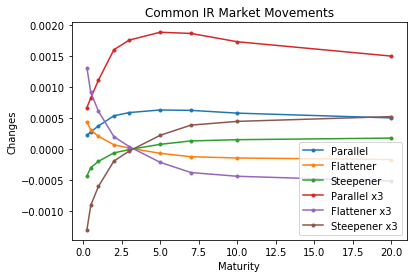

In [49]:
x, v = np.linalg.eig(cov)

d1 = sqrt(x[0])*v[:, 0]*1e-4
d2 = sqrt(x[1])*v[:, 1]*1e-4
d3 = -sqrt(x[1])*v[:, 1]*1e-4

ds = np.array([d1, d2, d3])
ds = np.concatenate((ds, 3.*ds))

plot(t, ds.T, '.-')
scenKey = ['Parallel', 'Flattener', 'Steepener', 'Parallel x3', 'Flattener x3',  'Steepener x3']
legend(scenKey, loc='best')
xlabel('Maturity')
ylabel('Changes')
title('Common IR Market Movements');

In [50]:
#build curves
s_cvs = []
for d in ds :
    c = lin.RationalTension(lbd)
    c.build(np.concatenate(([0.], t)), np.concatenate(([0.], r+d)))
    s_cvs.append(c)
    
#compute the PV changes under these typical market movements
d_pv =  np.array([np.array([r2pv(i, c) for c in s_cvs]) - r2pv(i, c1) for i in insts + [bespoke]])
pnl = hedged.dot(d_pv)
pnl.columns = scenKey

print("Hedging performance")
fmt.displayDF(pnl, "0f")

Hedging performance


,Parallel,Flattener,Steepener,Parallel x3,Flattener x3,Steepener x3
Unhedged,"-387,887","56,736","-56,701","-1,159,488","170,315","-169,996"
Full Hedge,48,-10,7,150,-42,9
Partial Hedge,"-184,739","35,616","-35,588","-551,878","106,936","-106,676"
Min Risk Hedge,"-171,101","33,234","-33,208","-511,147","99,780","-99,548"
Min Var Hedge,"-1,086","1,330","-1,341","-3,364","3,960","-4,053"


## (Extra credit) Problem 4 
 
The Brownian bridge method can be easily extended to multi-dimensional correlated Brownian motions. Assuming we have two browniam motion $x(t), y(t)$ with a correlation of 50%,

1. write a program to construct correlated Brownian Bridge from the given terminal values, correlation matrix and time increments, note that here you need to draw correlated Gaussian random numbers to perserve the correlation of the Brownian Bridge increments.
2. draw multiple paths from different terminal values and verify that the correlation of the increments of your Brownian Bridge is indeed 50%. Note that the terminal values can be drawn directly using the covariance matrix, which is known. 
3. suppose that you forgot about the correlation and used independent Gaussian random numbers in step 1, and have drawn the Brownian Bridges using correlated terminal values, but independent increments; Plot the resulting terminal value correlation between $\rho\left(x(t), y(t)\right)$ of the resulting Brownian Bridge over time $t$, explain your observation.